# My Favorite Pet

Goal:

To train 2 binary classification models: one for dogs and one for cats. And to combine them together to have a multiclass classification model.

In [9]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import layers
from keras.models import Sequential
import random
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [10]:
# !cp kaggle.json ~/.kaggle/
# !kaggle datasets download -d anirudhg15/mammals-classification
# !unzip /content/mammals-classification.zip

# Sources

- https://www.tensorflow.org/tutorials/images/classification

- https://www.kaggle.com/code/o07rohitjj/mammals-classification-with-efficientnet

- https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

# Data Exploration

In [11]:
data_path = 'mammals'
mammals = [f.name for f in os.scandir(data_path) if f.is_dir()]
mammals

['wolf', 'tiger', 'cat', 'elephant', 'lion', 'bear', 'dog', 'horse', 'goat']

### Separate dog data

In [12]:
dog_root = data_path + '/dog/'
dog_url = [dog_root+dog for dog in os.listdir(dog_root)]
dog_data = [Image.open(dog) for dog in dog_url]

## Example of how to read the image as numpy array

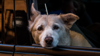

In [13]:
dog_1 = Image.open(dog_url[1])
# "thumbnail" is to shrink the image wihile keeping the aspect ratio
dog_1.thumbnail((100, 100))
dog_1.show()

In [14]:
# "reduced" is to shrink the image resolution by dividing the given value
dog_1_re = dog_1.reduce((10, 10))
dog_1_re.show()

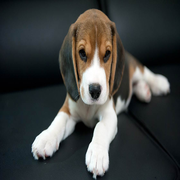

In [15]:
dog_0 = Image.open(dog_url[0])
# "resize" is to shrink the image to a given size
dog_0_r = dog_0.resize((180, 180), Image.ANTIALIAS)
dog_0_r.show()

# Data Preparation

### Loading data into a pandas data frame with one column of file paths and one column of labels

In [16]:
direc = Path('mammals')
filepaths = list(direc.glob(r'**/*.jpg'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))


filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)


img_df = pd.merge(filepaths, Labels, right_index=True, left_index=True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

img_df = img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,FilePaths,Labels
0,mammals/wolf/00000060.jpg,wolf
1,mammals/elephant/00000026.jpg,elephant
2,mammals/cat/00000021.jpg,cat
3,mammals/elephant/00000011.jpg,elephant
4,mammals/dog/00000071.jpg,dog


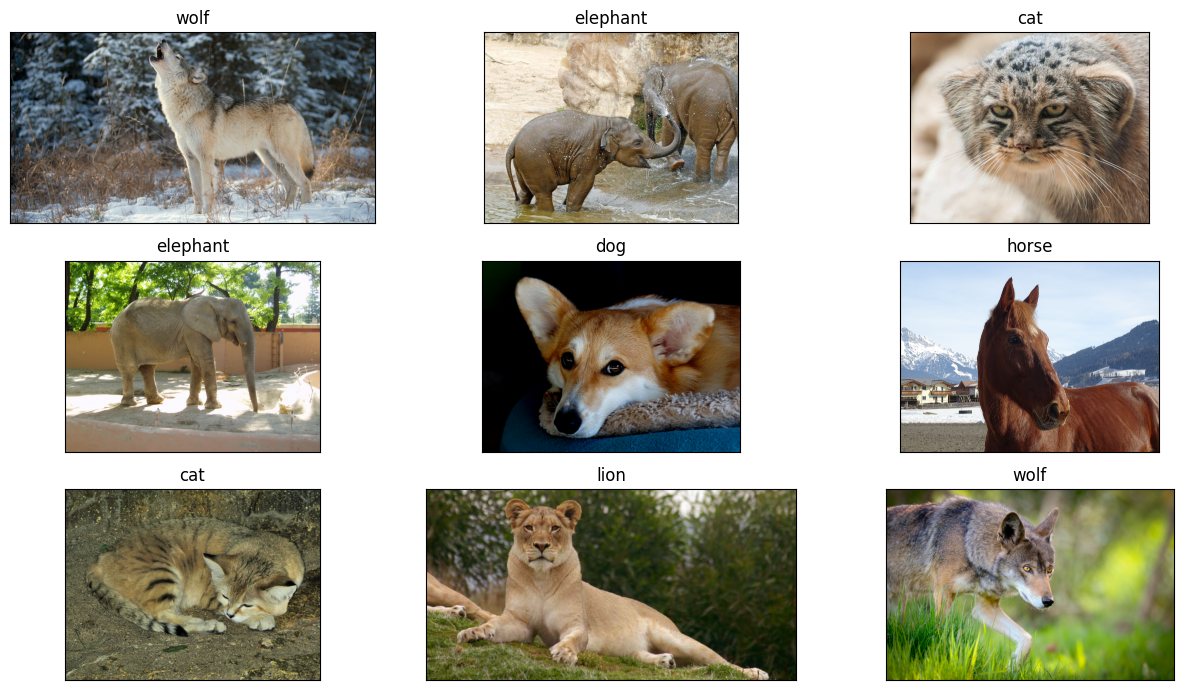

In [17]:
f, a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])

plt.tight_layout()
plt.show()

### Split training data

In [18]:
def divide_data(img_df, dog_or_cat='dog'):
    if dog_or_cat not in ['dog', 'cat']:
        raise ValueError("Invalid value for dog_or_cat. It should be either 'dog' or 'cat'.")
    main_animal_df = img_df[img_df.Labels==dog_or_cat]
    half = img_df.shape[0] // 2
    if dog_or_cat == 'dog':
        slice_animals = slice(0, half)
    else:
        slice_animals = slice(half, -1)
    all_animals_df = img_df[~img_df.Labels.isin(['dog', 'cat'])][slice_animals].sample(n = main_animal_df.shape[0], random_state=42)
    df = pd.concat([main_animal_df, all_animals_df]).sample(frac = 1, random_state=42)
    df['y'] = df.Labels == dog_or_cat
    return df

In [19]:
dog_train = divide_data(img_df, dog_or_cat='dog')
print(type(dog_train))
print('Training set size:', dog_train.shape)
print('Training set statistics', dog_train.Labels.value_counts())
print(dog_train.y.value_counts())
dog_train.head()

<class 'pandas.core.frame.DataFrame'>
Training set size: (190, 3)
Training set statistics dog         95
bear        16
lion        15
wolf        14
tiger       14
horse       13
elephant    13
goat        10
Name: Labels, dtype: int64
False    95
True     95
Name: y, dtype: int64


,FilePaths,Labels,y
5,mammals/horse/00000088.jpg,horse,False
84,mammals/wolf/00000049.jpg,wolf,False
481,mammals/lion/00000088.jpg,lion,False
546,mammals/dog/00000000.jpg,dog,True
484,mammals/tiger/00000012.jpg,tiger,False


In [20]:
cat_train = divide_data(img_df, dog_or_cat='cat')
print(type(cat_train))
print('Training set size:', cat_train.shape)
print('Training set statistics', cat_train.Labels.value_counts())
print(cat_train.y.value_counts())
cat_train.head()

<class 'pandas.core.frame.DataFrame'>
Training set size: (190, 3)
Training set statistics cat         95
wolf        18
elephant    17
bear        17
tiger       16
lion        12
goat         8
horse        7
Name: Labels, dtype: int64
False    95
True     95
Name: y, dtype: int64


,FilePaths,Labels,y
620,mammals/tiger/00000016.jpg,tiger,False
782,mammals/elephant/00000069.jpg,elephant,False
738,mammals/elephant/00000000.jpg,elephant,False
601,mammals/cat/00000033.jpg,cat,True
652,mammals/wolf/00000011.jpg,wolf,False


## Resize images by padding

In [21]:
def resize_image(pil_img, new_width=100, new_height=100, color='white'):
    right = left = top = bottom = 0
    width, height = pil_img.size
    if width > new_width and height > new_height:
        return pil_img.resize((100, 100))
    elif width < new_width:
        w = new_width - width
        left = w // 2
        right = w - left
    elif height < new_height:
        h = new_height - height
        top = h // 2
        bottom = h - top

    # new_width = width + right + left
    # new_height = height + top + bottom
    img_pad = Image.new(pil_img.mode, (new_width, new_height), color)
    img_pad.paste(pil_img, (left, top), mask=pil_img)
    return img_pad

In [22]:
# pass all the input samples to the a new pandas.DataFrame where the first column is the image matrix and the second column is the labels the third column is the target binary values
# resize the images, suppose the size of every given image is greater than 100 x 100
def read_image_matrix(img_path, new_size=(100, 100)):
    # read the image path fron the first column of the dataframe then read the image as a matrix
    try:
        img = Image.open(img_path)
        img_resize = img.resize(size=new_size)
        img_matrix = np.array(img_resize)
        return img_matrix
    except:
        return None

dog_train['Matrix'] = dog_train['FilePaths'].apply(read_image_matrix)
cat_train['Matrix'] = cat_train['FilePaths'].apply(read_image_matrix)

In [23]:
display(dog_train.head(), cat_train.head())

,FilePaths,Labels,y,Matrix
5,mammals/horse/00000088.jpg,horse,False,"[[[182, 208, 241], [182, 208, 240], [182, 208,..."
84,mammals/wolf/00000049.jpg,wolf,False,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
481,mammals/lion/00000088.jpg,lion,False,"[[[210, 225, 234], [209, 225, 234], [209, 226,..."
546,mammals/dog/00000000.jpg,dog,True,"[[[80, 77, 83], [81, 79, 86], [83, 83, 93], [8..."
484,mammals/tiger/00000012.jpg,tiger,False,"[[[172, 186, 113], [181, 191, 146], [165, 174,..."


,FilePaths,Labels,y,Matrix
620,mammals/tiger/00000016.jpg,tiger,False,"[[[119, 89, 65], [179, 132, 77], [129, 93, 56]..."
782,mammals/elephant/00000069.jpg,elephant,False,"[[[163, 184, 218], [167, 188, 222], [162, 186,..."
738,mammals/elephant/00000000.jpg,elephant,False,"[[[74, 82, 28], [67, 72, 17], [91, 69, 39], [6..."
601,mammals/cat/00000033.jpg,cat,True,"[[[79, 54, 35], [74, 49, 32], [67, 45, 27], [5..."
652,mammals/wolf/00000011.jpg,wolf,False,"[[[13, 3, 11], [14, 4, 14], [16, 5, 13], [17, ..."


In [24]:
def clean_data(data):
  i = 0
  for img in data['Matrix']:
      if np.array(img).shape not in [(100, 100, 3)]:
          i += 1
  print('Number of invaid images: ', i)

  # Clean the data by removing the damaged images
  data = data[data['Matrix'].apply(lambda x: np.array(x).shape == (100, 100, 3))]
  return data.reset_index(drop=True)

def transform_data(data):
  img_mat = pd.DataFrame({'image_matrix': data['Matrix'], 'label': data['y']})
  img_mat['label'] = img_mat['label'].astype(int)
  return img_mat


In [25]:
print('Cat')
cat_train = clean_data(cat_train)
print('Dog')
dog_train = clean_data(dog_train)

Cat
Number of invaid images:  0
Dog
Number of invaid images:  2


In [26]:
print('Cat')
cat_img_mat = transform_data(cat_train)
print('Dog')
dog_img_mat = transform_data(dog_train)
display(cat_img_mat.head(), dog_img_mat.head())

Cat
Dog


,image_matrix,label
0,"[[[119, 89, 65], [179, 132, 77], [129, 93, 56]...",0
1,"[[[163, 184, 218], [167, 188, 222], [162, 186,...",0
2,"[[[74, 82, 28], [67, 72, 17], [91, 69, 39], [6...",0
3,"[[[79, 54, 35], [74, 49, 32], [67, 45, 27], [5...",1
4,"[[[13, 3, 11], [14, 4, 14], [16, 5, 13], [17, ...",0


,image_matrix,label
0,"[[[182, 208, 241], [182, 208, 240], [182, 208,...",0
1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
2,"[[[210, 225, 234], [209, 225, 234], [209, 226,...",0
3,"[[[80, 77, 83], [81, 79, 86], [83, 83, 93], [8...",1
4,"[[[172, 186, 113], [181, 191, 146], [165, 174,...",0


In [27]:
# check the statistics
def check_stats(img_mat):
  print('Statistics: ', img_mat.label.value_counts())
  print('Size of processed images: ', img_mat.iloc[1]['image_matrix'].shape)
  # print('An image matrix example: ', img_mat.iloc[1]['image_matrix'])

print('Cat')
check_stats(cat_img_mat)
print('Dog')
check_stats(dog_img_mat)

Cat
Statistics:  0    95
1    95
Name: label, dtype: int64
Size of processed images:  (100, 100, 3)
Dog
Statistics:  0    95
1    93
Name: label, dtype: int64
Size of processed images:  (100, 100, 3)


one dog image and one non-dog image are removed due to damage reason

## Train a Convolutional Neural Network for Classification



### Prepare the training data

In [28]:
X_train_cat = np.stack(cat_img_mat['image_matrix'].values)
X_train_cat = X_train_cat.astype('float32') / 255.0
X_train_cat = X_train_cat.reshape(-1, 100, 100, 3)

y_train_cat = cat_img_mat['label'].values

In [29]:
X_train_dog = np.stack(dog_img_mat['image_matrix'].values)
X_train_dog = X_train_dog.astype('float32') / 255.0
X_train_dog = X_train_dog.reshape(-1, 100, 100, 3)

y_train_dog = dog_img_mat['label'].values

### Build CNN model

In [30]:
def reset_seeds():
    os.environ['PYTHONHASHSEED']=str(2)
    tf.random.set_seed(2)
    np.random.seed(2)
    random.seed(2)
reset_seeds()

#### Cat model

In [31]:
model_cat = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [32]:
model_cat.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cat.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 76832)             0         
                                                                 
 dense (Dense)               (None, 64)                4917312   
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,918,273
Trainable params: 4,918,273
Non-trainable params: 0
______________________________________________

In [33]:
cb = keras.callbacks.EarlyStopping(
    monitor="accuracy",
    patience=3,
    restore_best_weights=True
)

Epoch 1/30
6/6 [==============================] - 4s 445ms/step - loss: 2.4157 - accuracy: 0.5316
Epoch 2/30
6/6 [==============================] - 2s 288ms/step - loss: 0.8223 - accuracy: 0.5158
Epoch 3/30
6/6 [==============================] - 1s 246ms/step - loss: 0.7373 - accuracy: 0.4684
Epoch 4/30
6/6 [==============================] - 2s 247ms/step - loss: 0.6504 - accuracy: 0.5789
Epoch 5/30
6/6 [==============================] - 1s 243ms/step - loss: 0.6214 - accuracy: 0.6895
Epoch 6/30
6/6 [==============================] - 1s 245ms/step - loss: 0.5533 - accuracy: 0.8263
Epoch 7/30
6/6 [==============================] - 2s 263ms/step - loss: 0.4679 - accuracy: 0.8684
Epoch 8/30
6/6 [==============================] - 2s 257ms/step - loss: 0.4035 - accuracy: 0.9263
Epoch 9/30
6/6 [==============================] - 3s 456ms/step - loss: 0.3419 - accuracy: 0.9263
Epoch 10/30
6/6 [==============================] - 2s 252ms/step - loss: 0.2810 - accuracy: 0.9579
Epoch 11/30
6/6 [==

<Axes: >

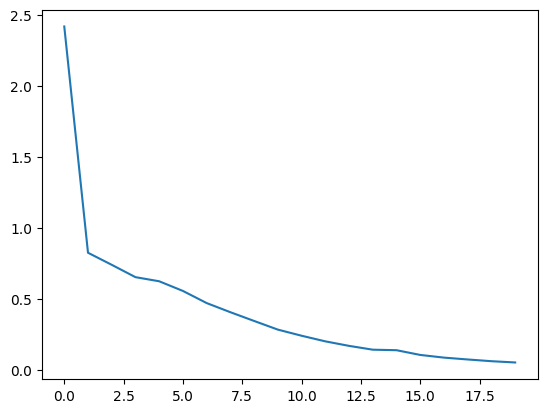

In [34]:
reset_seeds()
fitted_model = model_cat.fit(X_train_cat, y_train_cat, epochs=30, batch_size=32, callbacks=cb)
pd.Series(fitted_model.history['loss']).plot(label='train')

#### Dog model

In [35]:
model_dog = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [36]:
model_dog.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_dog.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 76832)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                4917312   
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,918,273
Trainable params: 4,918,273
Non-trainable params: 0
____________________________________________

Epoch 1/30
6/6 [==============================] - 2s 259ms/step - loss: 3.9822 - accuracy: 0.3883
Epoch 2/30
6/6 [==============================] - 1s 248ms/step - loss: 1.2831 - accuracy: 0.4734
Epoch 3/30
6/6 [==============================] - 2s 381ms/step - loss: 0.6897 - accuracy: 0.5106
Epoch 4/30
6/6 [==============================] - 2s 310ms/step - loss: 0.6924 - accuracy: 0.5106
Epoch 5/30
6/6 [==============================] - 1s 241ms/step - loss: 0.7003 - accuracy: 0.5106
Epoch 6/30
6/6 [==============================] - 1s 235ms/step - loss: 0.6874 - accuracy: 0.5585
Epoch 7/30
6/6 [==============================] - 1s 236ms/step - loss: 0.6741 - accuracy: 0.5957
Epoch 8/30
6/6 [==============================] - 1s 249ms/step - loss: 0.6431 - accuracy: 0.7128
Epoch 9/30
6/6 [==============================] - 1s 239ms/step - loss: 0.6086 - accuracy: 0.7500
Epoch 10/30
6/6 [==============================] - 1s 240ms/step - loss: 0.5622 - accuracy: 0.8670
Epoch 11/30
6/6 [==

<Axes: >

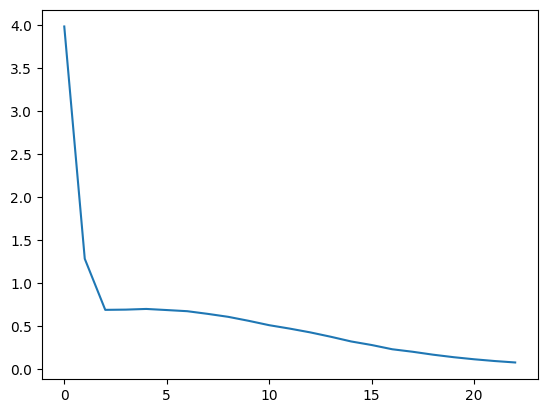

In [37]:
reset_seeds()
fitted_model = model_dog.fit(X_train_dog, y_train_dog, epochs=30, batch_size=32, callbacks=cb)
pd.Series(fitted_model.history['loss']).plot(label='train')

#### Combine 2 models

In [38]:
input_layer = tf.keras.layers.Input(shape=(100, 100, 3))

output_cat = model_cat(input_layer)
output_dog = model_dog(input_layer)

catdog_model = tf.keras.layers.concatenate([output_cat, output_dog])

catdog_model = tf.keras.Model(inputs=input_layer, outputs=catdog_model)

### Test

In [39]:
predictions_cat = catdog_model.predict(X_train_cat[y_train_cat==1][0:5])
predictions_cat

1/1 [==============================] - 0s 156ms/step


array([[0.9501726 , 0.83637697],
       [0.9828601 , 0.53851295],
       [0.9389189 , 0.8291    ],
       [0.9692741 , 0.31843603],
       [0.89274573, 0.71482885]], dtype=float32)

In [40]:
predictions_dog = catdog_model.predict(X_train_dog[y_train_dog==1][0:5])
predictions_dog

1/1 [==============================] - 0s 45ms/step


array([[0.59663457, 0.9491076 ],
       [0.509042  , 0.9182814 ],
       [0.73987997, 0.96248674],
       [0.44868383, 0.96265906],
       [0.625553  , 0.7455979 ]], dtype=float32)

In [42]:
# Compare the predictions
for i in range(len(predictions_cat)):
    prediction_cat, prediction_dog = predictions_cat[i]
    thr = 0.8
    dog_class = 1 if prediction_dog > thr else 0
    cat_class = 1 if prediction_cat > thr else 0
    if dog_class == 1 and cat_class == 1:
        print("Both models predict it's a dog and a cat")
    elif dog_class == 1:
        print("Model_dog predicts it's a dog")
    elif cat_class == 1:
        print("Model_cat predicts it's a cat")
    else:
        print("Both models predict it's neither a dog nor a cat")


Both models predict it's a dog and a cat
Model_cat predicts it's a cat
Both models predict it's a dog and a cat
Model_cat predicts it's a cat
Model_cat predicts it's a cat


Conclusions:

The results are not good because the training dataset is too small. But as we did this project for educational purposes, we're happy to achieve any metrics, because it's an experiment.